# General data analysis

Data analysis at city level based on the results for the 15 minute city methodology. This will include
* Average time within each city
* Main missing amenity
* Population percentage by time range
* Average time to each amenity
* Marginalization vs time

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/vscode/anaconda3/envs/odc/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Donwload data

Donwload hexagon and time data from specified cities

In [5]:
cities = ['ZMVM','Guadalajara',
         'Monterrey','Cancun','Tijuana',
         'Leon','Morelia','Aguascalientes',
         'Merida','Pachuca','Toluca','Queretaro']

In [6]:
cities = str(tuple(cities))
schema = 'prox_analysis'
table = 'time_15_min_analysis_hexres8'
cve_column = 'city'
query = f'SELECT * FROM {schema}.{table} WHERE "{cve_column}" IN {cities}'

In [7]:
gdf = aup.gdf_from_query(query, geometry_col='geometry')
print(gdf.shape)
gdf.head(2)

(11787, 30)


,hex_id_8,geometry,max_escuelas,max_preescolar,max_primaria,max_secundaria,max_servicios comunitarios,max_salud,max_guarderías,max_asistencia social,...,max_idx_15_min,pobtot,pobfem,pobmas,pob_0a14,pob_15a24,pob_25a59,p_60ymas,dens_pobha,city
0,88498e36dbfffff,"POLYGON ((-102.34777 21.92336, -102.34267 21.9...",15.057619,13.586498,15.057619,11.969535,62.167866,53.640209,50.912589,62.167866,...,71.010665,264.7125,131.68126,133.03125,75.937500,50.962500,117.731249,20.081251,3.063433,Aguascalientes
1,88498e36d5fffff,"POLYGON ((-102.32839 21.92505, -102.32329 21.9...",41.764955,22.511213,23.594408,41.764955,49.597804,49.597804,23.166648,33.483284,...,49.597804,1040.9625,542.34850,498.61400,142.968993,171.018986,497.508140,228.414930,12.047757,Aguascalientes


Change city names

In [12]:
def city_names(city):
    if city == 'Cancun':
        city == 'Cancún'
    elif city == 'Leon':
        city = 'León'
    elif city == 'Merida':
        city = 'Mérida'
    elif city == 'Queretaro':
        city = 'Querétaro'
    return city

In [13]:
gdf['city'] = gdf.city.apply(city_names)

In [16]:
gdf.loc[gdf.city=='Cancun','city'] = 'Cancún'

## Data analysis

### Time by city

In [18]:
gdf['wgt_max_idx_15_min'] =(gdf['max_idx_15_min'] * gdf['pobtot'])/gdf.groupby('city')['pobtot'].transform('sum')
df_wgt_avg = gdf[['city','wgt_max_idx_15_min']].groupby('city').sum()
df_wgt_avg

,wgt_max_idx_15_min
city,
Aguascalientes,65.877561
Cancún,54.194363
Guadalajara,66.390274
León,55.227166
Monterrey,59.527438
Morelia,66.309843
Mérida,67.633569
Pachuca,71.822048
Querétaro,84.979096


In [19]:
gdf[['city','max_idx_15_min']].groupby('city').mean()

,max_idx_15_min
city,
Aguascalientes,92.188233
Cancún,89.989521
Guadalajara,101.027956
León,83.591583
Monterrey,82.695496
Morelia,102.357382
Mérida,97.604972
Pachuca,108.585525
Querétaro,130.847397


In [20]:
df_wgt_avg

,wgt_max_idx_15_min
city,
Aguascalientes,65.877561
Cancún,54.194363
Guadalajara,66.390274
León,55.227166
Monterrey,59.527438
Morelia,66.309843
Mérida,67.633569
Pachuca,71.822048
Querétaro,84.979096


In [27]:
df_wgt_avg = df_wgt_avg.reset_index()
df_wgt_avg.head(2)

,level_0,index,city,wgt_max_idx_15_min
0,0,0,Aguascalientes,65.877561
1,1,1,Cancún,54.194363


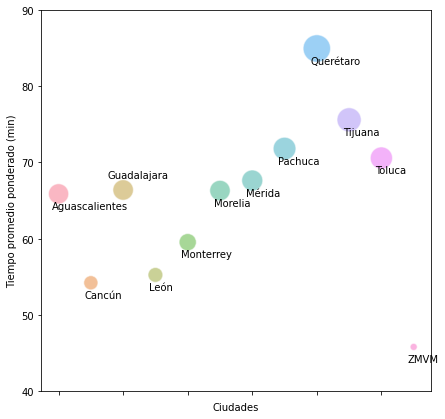

In [28]:
fig,ax = plt.subplots(figsize=(7,7))

sns.scatterplot(data=df_wgt_avg, x=df_wgt_avg.index, y=df_wgt_avg.wgt_max_idx_15_min,
                size=df_wgt_avg.wgt_max_idx_15_min, sizes=(50,750), alpha=0.5,
               hue = 'city', legend=False, ax=ax)
ax.set(xticklabels=[])
plt.xlabel('Ciudades')
plt.ylabel('Tiempo promedio ponderado (min)')
plt.ylim(40,90)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if point['val'] == 'Guadalajara':
            ax.text(point['x']-0.5, point['y']+1.5, str(point['val']))
        else:
            ax.text(point['x']-0.2, point['y']-2, str(point['val']))

label_point(df_wgt_avg['level_0'], df_wgt_avg.wgt_max_idx_15_min, df_wgt_avg.city, plt.gca())

### Main missing ammenity

In [29]:
lista_amenidades = ['max_preescolar','max_primaria',
                    'max_secundaria','max_salud','max_guarderías',
                    'max_asistencia social','max_alimentos','max_personal',
                    'max_farmacias','max_hogar','max_complementarios','max_social',
                    'max_actividad física', 'max_cultural']

missing_column_name = 'Equipamiento/servicio prioritario'

gdf[missing_column_name] = 'No aplica'
idx = gdf['max_idx_15_min']>15
gdf.loc[idx,missing_column_name] = gdf[lista_amenidades].idxmax(axis=1)

In [30]:
gdf_equipamiento = gdf[['city',missing_column_name]].groupby('city').value_counts().reset_index().rename(columns={0:'contador'})
gdf_equipamiento = gdf_equipamiento.groupby('city').max().reset_index().drop(columns=[missing_column_name]).merge(gdf_equipamiento, on=['city','contador'])
gdf_equipamiento['pct_max'] = gdf_equipamiento['contador'] / len(gdf)
gdf_equipamiento

,city,contador,Equipamiento/servicio prioritario,pct_max
0,Aguascalientes,494,max_cultural,0.041911
1,Cancún,189,max_cultural,0.016035
2,Guadalajara,924,max_cultural,0.078391
3,León,365,max_cultural,0.030966
4,Monterrey,902,max_cultural,0.076525
5,Morelia,215,max_cultural,0.018240
6,Mérida,369,max_cultural,0.031306
7,Pachuca,217,max_cultural,0.018410
8,Querétaro,332,max_cultural,0.028167
9,Tijuana,870,max_cultural,0.073810


### Population by time range

In [65]:
def index_time_group(time_column):
    if time_column <= 15:
        time_group = '0-15min'
    elif time_column <= 30:
        time_group = '15-30min'
    elif time_column <= 45:
        time_group = '30-45min'
    elif time_column <= 60:
        time_group = '45-60min'
    else:
        time_group = '> 60min'
    return time_group

In [77]:
gdf['time_group'] = gdf.max_idx_15_min.apply(index_time_group)

In [78]:
gdf_group = gdf.groupby(['city','time_group']).sum()
gdf_group = gdf_group['pobtot'].copy()
gdf_group = gdf_group.reset_index()
gdf_group['pct_pobtot'] = 100 * gdf_group['pobtot'] / gdf_group.groupby('city')['pobtot'].transform('sum')

In [79]:
gdf_group.head(4)

,city,time_group,pobtot,pct_pobtot
0,Aguascalientes,0-15min,115366.130400,5.535238
1,Aguascalientes,15-30min,348757.629800,16.733305
2,Aguascalientes,30-45min,376762.852740,18.076988
3,Aguascalientes,45-60min,329284.650234,15.798996


In [80]:
#categorical data
cat_list = ['0-15min','15-30min','30-45min', 
            '45-60min','> 60min']

cat_size_order = CategoricalDtype(
    cat_list, 
    ordered=True)

gdf_group['time_group'] = gdf_group['time_group'].astype(cat_size_order)
gdf_group = gdf_group.sort_values('time_group')

<AxesSubplot:xlabel='time_group', ylabel='pct_pobtot'>

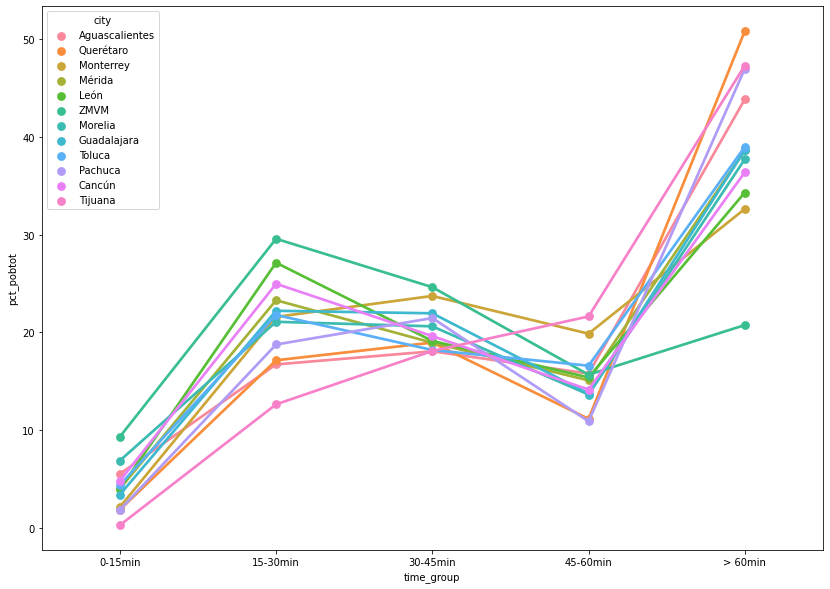

In [81]:
fig,ax = plt.subplots(figsize=(14,10))

sns.pointplot(data=gdf_group, x="time_group", y="pct_pobtot", hue='city',
             ax=ax)

In [82]:
gdf_group['Porcentaje de población acumulada (%)'] = gdf_group.groupby('city')['pct_pobtot'].transform(pd.Series.cumsum)

In [83]:
gdf_group = gdf_group.rename(columns={'city':'Ciudades',
                                     'time_group':'Categoría de tiempo'})

<AxesSubplot:xlabel='Categoría de tiempo', ylabel='Porcentaje de población acumulada (%)'>

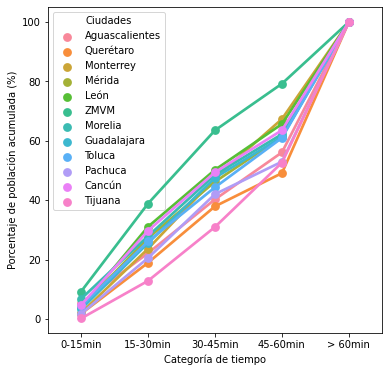

In [85]:
fig,ax = plt.subplots(figsize=(6,6))

sns.pointplot(data=gdf_group, x="Categoría de tiempo", y='Porcentaje de población acumulada (%)'
              , hue='Ciudades',
             ax=ax)

Cumulative distribution

### Average time to each ammenity

In [42]:
gdf_time_by_amenity = gdf.groupby('city').mean()[lista_amenidades].stack().reset_index().rename(columns={'level_1':'Equipamiento/Servicio',
                                                                                  0:'tiempo (min)'})
gdf_time_by_amenity.head(2)

,city,Equipamiento/Servicio,tiempo (min)
0,Aguascalientes,max_preescolar,19.174252
1,Aguascalientes,max_primaria,19.586162


In [43]:
gdf_time_by_amenity['Equipamiento/Servicio'].unique()

array(['max_preescolar', 'max_primaria', 'max_secundaria', 'max_salud',
       'max_guarderías', 'max_asistencia social', 'max_alimentos',
       'max_personal', 'max_farmacias', 'max_hogar',
       'max_complementarios', 'max_social', 'max_actividad física',
       'max_cultural'], dtype=object)

In [44]:
def amenity_name(amenity_code):
    dict_names = {'max_preescolar':'Preescolar',
                 'max_primaria':'Primaria',
                 'max_secundaria':'Secundaria',
                  'max_guarderías':'Guardería',
                 'max_salud':'Salud - primer contacto',
                 'max_asistencia social':'Centro de asistencia social',
                 'max_alimentos':'Comercio de productos alimenticios',
                 'max_personal':'Comercio para el cuidado personal',
                 'max_farmacias':'Farmacia',
                 'max_hogar':'Comercio de artículos para el hogar',
                 'max_complementarios':'Comercio barrial complementario',
                 'max_social':'Sitios de esparcimiento social',
                 'max_actividad física':'Espacios para la actividad física',
                 'max_cultural':'Sitios de esparcimiento cultural',
                 'No aplica':'No aplica'}
    return dict_names[amenity_code]

In [45]:
gdf_time_by_amenity['Equipamiento/Servicio'] = gdf_time_by_amenity['Equipamiento/Servicio'].apply(amenity_name)

In [46]:
import textwrap
def wrap_labels(ax, width, rotation, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=rotation)

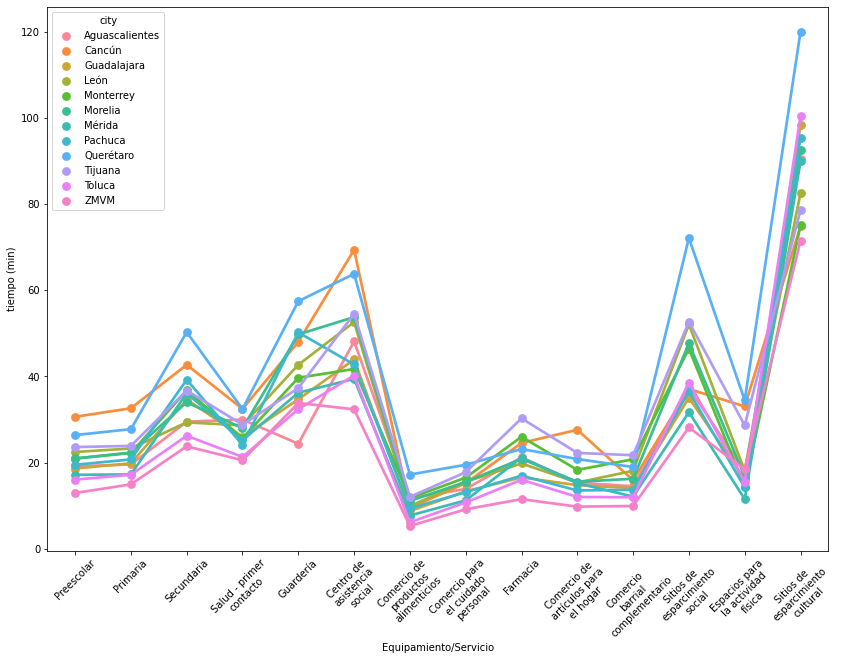

In [47]:
fig,ax = plt.subplots(figsize=(14,10))
sns.pointplot(data=gdf_time_by_amenity, x="Equipamiento/Servicio", y="tiempo (min)", 
              hue='city', ax=ax)
wrap_labels(ax, 15, 45)

## Polar Graph

In [48]:
import math #importing the math functions

pi = math.pi

In [49]:
list_categorias = ['max_escuelas','max_servicios comunitarios',
                  'max_entretenimiento','max_comercio']

In [50]:
gdf_polar = gdf.groupby('city').mean()[list_categorias].reset_index()
df = gdf_polar.copy()

Rosa de los vientos

In [51]:
def make_spider(df, row, color, title, alpha, linewidth):
    
    categories=list(df)[0:]
    N = len(categories)

    
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
     
    plt.rc('figure', figsize=(5, 5), )
 
    ax = plt.subplot(1,1,1, polar=True, )
 
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
 
   
    plt.xticks(angles[:-1], categories, color='black', size=8,)
    ax.tick_params(axis='x', rotation=0,pad=18)
    # ax.set_xlabel(labelpad=10)
    
    ax.set_rlabel_position(0)
    plt.yticks([15,30,40,60], ['15','30','45','60'], color="black", size=10)
    plt.ylim(0,60)
     
    
    values=df.reset_index().loc[row].values.tolist()[1:]
    values += values[:1]
    ax.plot(angles, values, color = color, linewidth=linewidth, linestyle='solid')
    ax.fill(angles, values, color = color, alpha = alpha)
         
    wrap_labels(ax, 15, 0)
  
    # title = "Radar showing performance in each subject for "+ title
    # plt.title(title, fontsize=20, x = 0.5, y = 1.1)

In [52]:
categories=list(df)[0:]
N = len(categories)


angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

In [53]:
import textwrap
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D

In [58]:
df = df.set_index('city')
df = df.rename(columns={'max_escuelas':'Educativo',
                       'max_servicios comunitarios':'Servicios comunitarios',
                       'max_entretenimiento':'Entretenimiento',
                       'max_comercio':'Comercio'})

In [55]:
def wrap_labels(ax, width, rotation, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=rotation, )

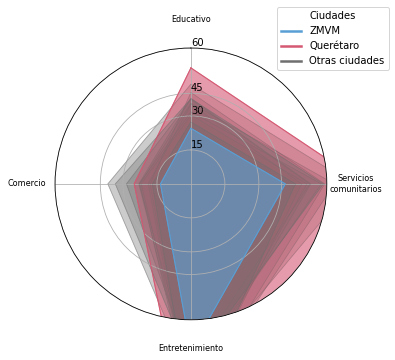

In [60]:
plt.figure()
for i in range(len(df)):
    if df.index[i] == 'ZMVM':
        color = '#599fd5'
        make_spider(row=i, df = df,title ='Ciudad' , 
                    color = color, alpha=0.6, linewidth=1)
        # plt.legend([Line2D([0], [0], color=color, lw=4)], [df.index[i]])
    elif df.index[i] == 'Querétaro':
        color = '#d55973'
        make_spider(row=i, df = df,title ='Ciudad' , 
                    color = color, alpha=0.6, linewidth=1)
        # plt.legend([Line2D([0], [0], color=color, lw=4)], [df.index[i]])
    else:
        color = '#6f6f6f'
        make_spider(row=i, df = df,title ='Ciudad' , 
                    color = color, alpha=0.35, linewidth=0.2)
        
color_lines = [Line2D([0], [0], color='#599fd5', lw=2.5),
              Line2D([0], [0], color='#d55973', lw=2.5),
              Line2D([0], [0], color='#6f6f6f', lw=2.5)]
# ax.legend([], [df.index[row]])
plt.legend(color_lines, ['ZMVM', 'Querétaro', 'Otras ciudades'],
          bbox_to_anchor=(0.8,0.9),title='Ciudades',)